# Import Packages

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import urllib
import zipfile
import glob
import os
from shapely.geometry import Point
from geopandas import GeoDataFrame
import random as rd
%matplotlib inline


# Import and Clean Data

For this mini project, we will need 2 layers: **Public transit stations** and **COVID-19 vaccination clinic locations**

In [2]:
try:
    os.mkdir('downloads')
except:
    print('folder exists')

In [3]:
def download_unzip_shp(link, foldername):
    # download shapefile as a zipped folder
    urllib.request.urlretrieve(link, foldername + ".zip")
    
    # unzip to another folder
    with zipfile.ZipFile(foldername + ".zip","r") as zip_ref:
        zip_ref.extractall(foldername)

    shp_name = glob.glob(foldername + '/*.shp')
    
    return shp_name

In [4]:
# bus stations:
## check this link: https://data.cityofnewyork.us/Transportation/Bus-Stop-Shelters/qafz-7myz
buslink = "https://data.cityofnewyork.us/api/geospatial/qafz-7myz?method=export&format=Shapefile"
busname = "downloads/bus_shp"
bus_shp = download_unzip_shp(buslink, busname)

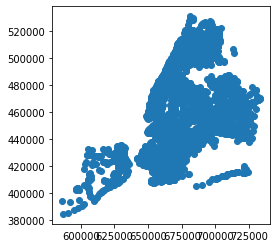

In [5]:
bus = gpd.read_file(bus_shp[0])

# convert from GCS to PCS for further actions
bus = bus.to_crs(epsg=6434)

bus.plot()
plt.show()

In [6]:
# uncomment to check the shapefile coordinate system
#bus.crs

In [7]:
# metro stations:
## check this link: https://data.cityofnewyork.us/Transportation/Subway-Stations/arq3-7z49
metrolink = "https://data.cityofnewyork.us/api/geospatial/arq3-7z49?method=export&format=Shapefile"
metroname = "downloads/metro_shp"
metro_shp = download_unzip_shp(metrolink, metroname)

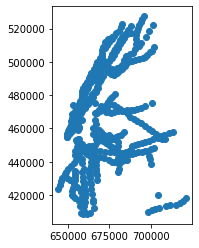

In [8]:
metro = gpd.read_file(metro_shp[0])
# convert from GCS to PCS for further actions
metro = metro.to_crs(epsg=6434)
metro.plot()
plt.show()

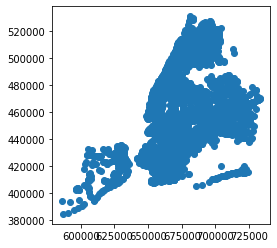

In [9]:
# join them together:
bshort = bus[['shelter_id','geometry']]
mshort = metro[['name','geometry']]
transit = gpd.GeoDataFrame( pd.concat([bshort, mshort], ignore_index=True) )
transit.plot()
plt.show()

In [10]:
transit['ID'] = transit.index


In [11]:
# uncomment to check the shapefile coordinate system
#metro.crs

In [12]:
# if you would like to download a .csv version: try codes below
# # bus stations:
# urllib.request.urlretrieve("https://data.cityofnewyork.us/api/geospatial/qafz-7myz?method=export&format=Shapefile", "bus.csv")

# # metro stations:
# urllib.request.urlretrieve("https://data.cityofnewyork.us/api/views/kk4q-3rt2/rows.csv?accessType=DOWNLOAD", "metro.csv")

In [13]:
# census tracts:
## check this link: https://data.cityofnewyork.us/City-Government/2010-Census-Tracts/fxpq-c8ku
ctlink = "https://data.cityofnewyork.us/api/geospatial/fxpq-c8ku?method=export&format=Shapefile"
ctname = "downloads/2010 Census Tracts_shp"
ct_shp = download_unzip_shp(ctlink, ctname)

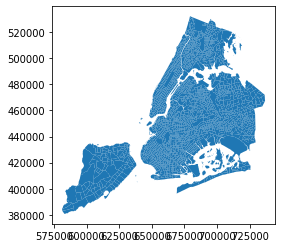

In [14]:
ct = gpd.read_file(ct_shp[0])

# convert from GCS to PCS for further actions
ct = ct.to_crs(epsg=6434)

ct.plot()
plt.show()

In [15]:
# uncomment to check the shapefile coordinate system
#ct.crs

In [16]:
# vaccine station
# the processing notebook is in the floder
# several geocoding errors are fixed manually
vs = pd.read_csv('Vac_station_final.csv')
vs.head(2)

,ID,Name,Address,Notes,Phone_Number,Station_Type,Vaccine_Type,Notes.1,formatted_address,latitude,longitude
0,0,Abyssinian Baptist Church- Pop Up,"132 West 138th Street, Manhattan","$100 incentive available , Walk-up vaccination...",(877) 829-4692,Pop Up - Van,Vaccines offered:Pfizer (12+)Johnson & Johnson...,"$100 incentive available , Walk-up vaccination...","132 W 138th St, New York, NY 10030, USA",40.816682,-73.941556
1,1,AMC Magic Johnson Harlem- Pop Up,"2309 Frederick Douglass Blvd, Manhattan","$100 incentive available , Walk-up vaccination...",(877) 829-4692,Pop Up - Bus,Vaccine offered:Pfizer (5-11),"$100 incentive available , Walk-up vaccination...","2309 Frederick Douglass Blvd, New York, NY 100...",40.809686,-73.951782


In [17]:
## generate geo-spatial dataframe using csv files
geometry = [Point(xy) for xy in zip(vs.longitude, vs.latitude)]
vs = GeoDataFrame(vs, geometry=geometry)
vs.set_crs(epsg=4326, inplace=True)
vs = vs.to_crs(epsg=6434)
#vs.head(1)

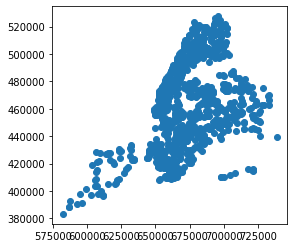

In [18]:
vs.plot()
plt.show()

# Analysis

In [19]:
plt.rcParams["figure.figsize"] = (10,10) # change the plots to a larger size

### First, select a random station

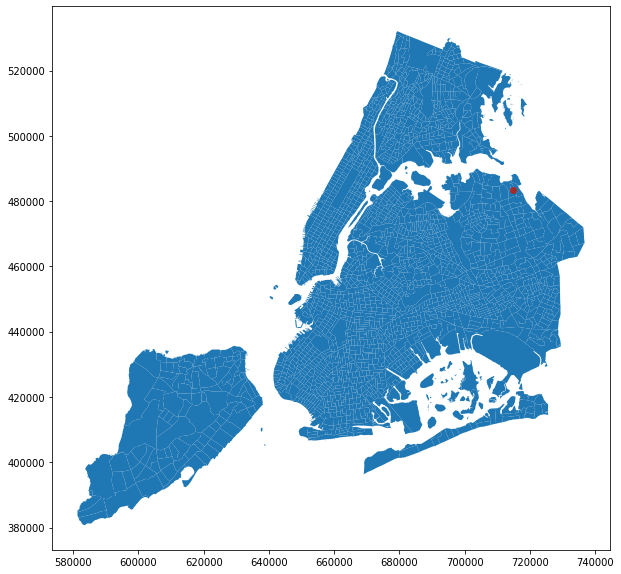

In [20]:
# select 1 random station:
station_code = rd.randrange(3896) 
station = transit[transit['ID'] == station_code]

# plot both the select station and the census tracts
ax = ct.plot()
station.plot(ax=ax, color='brown')
plt.show()

### Then, generate 1 mile radius buffer and clip census tract to 3 mile bounding box

C:\Users\yunhe\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:6434
Right CRS: None

  


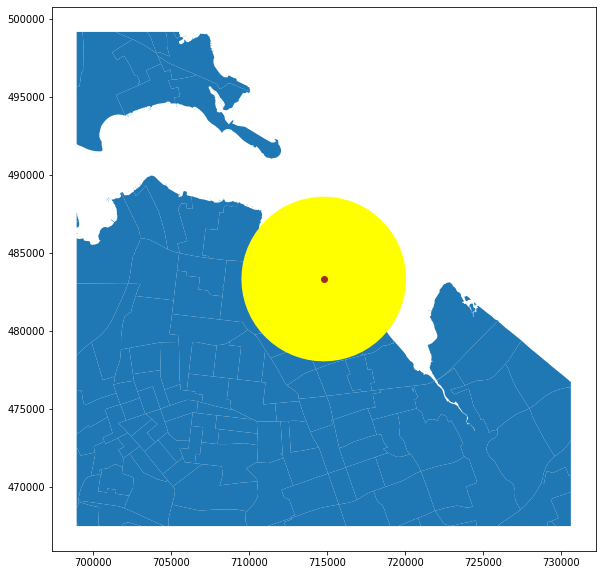

In [21]:
radius = 1 * 5280 ## convert 1 mile radius to 5280 ft

# generate buffer around the selected station
buffer = station.geometry.buffer(radius)
bounding = station.buffer(radius * 3, cap_style=3) ## 3 is square bounding
ct_clip = gpd.clip(ct,bounding)

ax = ct_clip.plot()
buffer.plot(ax=ax, color='yellow')
station.plot(ax=ax, color='brown')
plt.show()


###  Next, clip vaccination station layer with bounding box, and futher select vaccination stations in 1-mile buffer

C:\Users\yunhe\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:6434
Right CRS: None

  


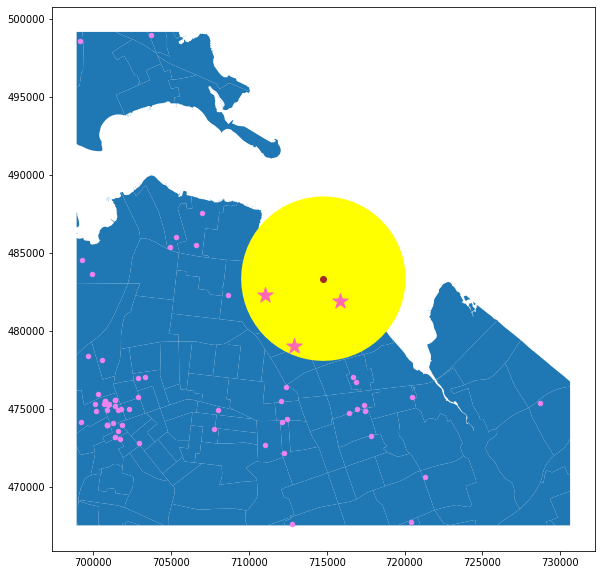

In [22]:
vac_clip = gpd.clip(vs,buffer)
other_vac_clip = gpd.clip(vs,bounding)


ax = ct_clip.plot()
buffer.plot(ax=ax, color='yellow')
station.plot(ax=ax, color='brown')

other_vac_clip.plot(ax=ax, marker = "o", markersize=20, color = 'violet')
vac_clip.plot(ax=ax, marker = "*", markersize=260, color = 'hotpink')

plt.show()

In [23]:
vac_clip.head()

,ID,Name,Address,Notes,Phone_Number,Station_Type,Vaccine_Type,Notes.1,formatted_address,latitude,longitude,geometry
68,68,NYC Vaccine Hub - Korean Community Services,"203-05 32nd Avenue, Queens","$100 incentive available , Walk-up vaccination...",(877) 829-4692,Community Health Center/Clinic,Vaccines offered:Pfizer (5-11)Pfizer (12+),"$100 incentive available , Walk-up vaccination...","203-05 32nd Ave, Flushing, NY 11361, USA",40.770949,-73.786463,POINT (712899.741 478991.509)
721,721,Walgreens/Duane Reade,"24-28 Bell Boulevard, Queens",NaN,(800) 925-4733,Pharmacy,Vaccine offered:Moderna (18+),NaN,"24-28 Bell Blvd, Bayside, NY 11360, USA",40.779062,-73.776015,POINT (715828.853 481912.856)
709,709,Walgreens/Duane Reade,"19-23 Utopia Parkway, Queens",NaN,(800) 925-4733,Pharmacy,Vaccine offered:Moderna (18+),NaN,"19-23 Utopia Pkwy, Whitestone, NY 11357, USA",40.779974,-73.793427,POINT (711010.623 482302.802)


In [24]:
# if you would like to generate shapefile/csv output, uncomment lines below
# os.mkdir('outputs')
# vac_clip.to_file(driver='ESRI Shapefile', filename = "outputs/vac_clip.shp")
# vac_clip.to_csv('outputs/vac_clip.csv')